# Deep Q-learning

*Elise Chin - Version 1, December 2021*


1. [Introduction Deep Q-learning](#sec1)
2. [Présentation de l'environnement CartPole](#sec2)
3. [Implémentation](#sec3)
    - [Replay Memory](#sec3-1)
    - [Deep Q Network](#sec3-2)
    - [`optimize` function](#sec3-3)
    - [`evaluate_policy` function](#sec3-4)
    - [Entraînement](#sec3-5)


## <a name="sec1">1. Introduction</a>



La méthode deep Q-learning a été introduite par Deepmind en 2013 (*Volodymyr Mnih et al. “Playing Atari with Deep Reinforcement Learning”*), puis améliorée en 2015 (*Volodymyr Mnih et al. “Human-level control through deep reinforcement learning”*). C'est une amélioration de l'algorithme Q-learning avec des réseaux de neurones utilisés comme une fonction d'approximation de la fonction de valeur optimale état-action.

__Q-learning__

Q-learning est un algorithme permettant de trouver une estimation $Q$ de la fonction de valeur optimale état-action $q_*$ à partir de l'expérience. La fonction $q$ d'une politique $\pi$, $q_{\pi}(s,a)$, correspond à l'espérence des récompenses obtenues en appliquant l'action $a$ sur l'état $s$, puis en suivant la politique $\pi$ ensuite. Autrement dit, elle nous indique à quel point il est bon de prendre cette action spécifique à cet état particulier. La fonction $q$ optimale est alors définie comme l'espérance maximale qui peut être obtenue à partir de l'observation $s$, en prenant l'action $a$, puis en suivant la politique optimale $\pi$. Elle obéit à l'équation d'optimalité de Bellman :
$$
q_∗(s,a) = \mathbb{E}[R_{t+1} + \gamma \underset{a'}{max}
q_*(S_{t+1},a')| S_t = s, A_t = a]
$$

où $R_{t+1}$ est la récompense immédiate, $S_{t+1}$ le prochain état après avoir effectué l'action $a$ depuis l'état $s$ au temps $t$.
La mise à jour Q-learning est basée sur l'équation d'optimalité de Bellman et est définie comme suit :
$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha(R_{t+1} + \gamma \underset{a}{max} Q(S_{t+1}, a) - Q(S_t, A_t))
$$
et on peut montrer que cela converge vers la fonction action-valeur optimale $q_*(s,a)$ lorsque $N(s,a) \rightarrow ∞$ si la taille de pas $\alpha$ diminue vers 0 avec un taux approprié.

__Deep Q-learning__

Dans Q-learning, une table `Q[s,a]` est construite pour stocker toutes les valeurs $q$ pour toutes les combinaisons possibles d'états et d'actions. Cependant, si l'espace d'état ou d'action est trop grand, la mémoire et les besoins en calcul pour Q-learning seront très élevés. Pour résoudre ce problème, il est possible d'entraîner une fonction d'approximation, par exemple un réseau de neurones avec des paramètres $w$, pour estimer les valeurs de $q$, c'est-à-dire $Q(s, a, w) ≈ q_∗(s, a)$. Ceci peut être
réalisée en minimisant l'erreur quadratique moyenne à chaque pas de temps $t$ :
$$
L(w_t) = \mathbb{E}[(U_t - Q(S_t, A_t, w_t))^2]
$$
où $U_t = R_{t+1} + \gamma \underset{a}{max} Q(S_{t+1}, a, w_t)$ est la cible TD (en anglais *TD-target*).

La fonction de perte peut être minimisée en utilisant l'algorithme de descente de (semi-)gradient stochastique :
$$
w_{t+1} = w_t + \alpha[U_t - Q(S_t, A_t, w_t)] \nabla Q(S_t, A_t, w_t)
$$
Cependant, l'apprentissage sera instable si nous appliquons naïvement la mise à jour standard de Q-learning. Comme nous pouvons le voir dans la formule, il existe une certaine corrélation entre les mises à jour successives, et l'estimation Q et la cible ne sont pas complètement indépendantes l'une de l'autre.


Pour résoudre ce problème, deux idées ont été introduites dans l'article de Deepmind.
1. __Experience replay__  : stocker l'expérience de l'agent à chaque pas de temps $t$, $e_t = (S_t, A_t, R_t, S_{t+1})$, dans un *replay buffer* et échantillonner des *mini-batches* de celui-ci pour entraîner le réseau, au lieu d'utiliser uniquement la dernière transition pour calculer le coût et le gradient.  Cela présente deux avantages : une meilleure stabilité puisque les transitions d'un batch ne sont pas corrélées, et une meilleure efficacité des données puisqu'une expérience peut être utilisée dans de nombreuses mises à jour de poids.
2. __Target Network__ : utiliser un réseau séparé pour estimer $U_t$. Le *target network* a la même architecture que le réseau de neurones approximant $q_*$ mais avec des poids gelés pour un certain nombre d'étapes. Plus précisément, tous les $C$ pas (un hyperparamètre), les paramètres du réseau Q sont copiés dans le réseau cible et ce dernier est utilisé pour calculer $U_t$ pour $C$ pas de temps. Cela permet une plus grande stabilité dans l'entraînement puisque la fonction cible est fixée pendant un certain temps.


Dans la suite, nous allons implémenter deep Q-learning sur l'environnement CartPole.



## <a name="sec2">2. Présentation de l'environnement CartPole-v0</a>



Un poteau est attaché à un chariot, qui peut se déplacer sur une piste sans frottement. Le poteau commence à la verticale et l'objectif est de l'empêcher de tomber en contrôlant le chariot.
- L'observation de l'environnement est un vecteur 4D représentant la position et la vitesse du chariot, ainsi que l'angle et la vitesse angulaire du poteau.
- L'agent peut contrôler le système en effectuant l'une des deux actions suivantes : pousser le chariot à droite ou à gauche.
- Une récompense de 1 est fournie pour chaque pas de temps où le poteau reste droit.
- L'épisode se termine lorsque l'une des situations suivantes est vraie :
    - le poteau bascule au-delà d'un certain angle limite
    - le chariot sort des limites du monde
    - 200 pas de temps s'écoulent

L'objectif de l'agent est de trouver une politique permettant de maximiser $G = \sum_{t=0}^{T} \gamma^t R_{t+1}$ de chaque épisode, où $\gamma \in (0, 1]$ est le taux d'escompte. Si l'agent a été bien entraîné, un épisode devrait se terminer en satisfaisant la troisième condition. Ainsi, l'agent final devrait avoir un rendement moyen de +200.0 sur plusieurs épisodes, ce qui correspond à recevoir une récompense de 1 pour 200 pas de temps.

## <a name="sec3">3. Implémentation</a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
import os

path = "/content/drive/My Drive/Dauphine/M2/S1/Reinforcement_Learning"
sys.path.append(path)
os.environ['DRIVE_PATH'] = path.replace(' ', ' ')
print(os.environ['DRIVE_PATH'])

/content/drive/My Drive/Dauphine/M2/S1/Reinforcement_Learning


In [3]:
import gym

import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
"""
memory_size: Maximum size of the replay memory.
n_episodes: Number of episodes to train for.
batch_size: Batch size used for training DQN.
target_update_frequency: How often to update the target network.
train_frequency: How often to train the DQN.
gamma: Discount factor.
lr: Learning rate used for optimizer.
eps_start: Starting value for epsilon (linear annealing).
eps_end: Final value for epsilon (linear annealing).
anneal_length: How many steps to anneal epsilon for.
n_actions: The number of actions can easily be accessed with env.action_space.n.
"""

# Hyperparameters for CartPole-v0
env_config = {
    'memory_size': 50000,
    'n_episodes': 1000,
    'batch_size': 32,
    'target_update_frequency': 100,
    'train_frequency': 1,
    'gamma': 0.95,
    'lr': 1e-4,
    'eps_start': 1.0,
    'eps_end': 0.05,
    'anneal_length': 10**4,
    'n_actions': 2,
}

In [6]:
def preprocess(obs):
    """Performs necessary observation preprocessing."""
    return torch.tensor(obs, device=device).float()

def plot_result(x, y, xlabel, ylabel, title):
	plt.plot(x, y)
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	plt.show()

### <a name="sec3-1">Replay Memory</a>

In [7]:
class ReplayMemory():

    def __init__(self, capacity):
        self.capacity = capacity # Maximum size of the replay memory
        self.memory = [] # Sore the agent’s experience at each time step t, e_t = (S_t, A_t, R_t, S_t+1)
        self.position = 0 # Position at which to save the next agent's experience

    def __len__(self):
        return len(self.memory)

    def push(self, obs, action, next_obs, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = (obs, action, next_obs, reward) # Add experience to the replay buffer
        self.position = (self.position + 1) % self.capacity # Position for the next experience to save

    def sample(self, batch_size):
        """
        Samples batch_size transitions from the replay memory and returns a tuple
            (obs, action, next_obs, reward)
        """
        sample = random.sample(self.memory, batch_size)
        return tuple(zip(*sample)) # ((obs1, obs2), (action1, action2), ...)


### <a name="sec3-2">Deep Q Network</a>

In [8]:
class DQN(nn.Module):
    def __init__(self, env_config):
        super(DQN, self).__init__()

        # Hyperparameters
        self.batch_size = env_config["batch_size"]
        self.gamma = env_config["gamma"]
        self.eps_start = env_config["eps_start"]
        self.eps_end = env_config["eps_end"]
        self.anneal_length = env_config["anneal_length"]
        self.n_actions = env_config["n_actions"]

        # Network's layers
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, self.n_actions)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def act(self, observation, epsilon, exploit=False):
        """Selects an action with an epsilon-greedy exploration strategy.

        Args:
            observation (tensor): observation tensor of shape [batch_size, state_dimension] (e.g. [32, 4])
            epsilon (int)
            exploit (bool): if True, acts greedily

        Returns:
            actions (tensor): tensor of actions according to the epsilon-greedy strategy, of shape [batch_size]
        """
		
        batch_size = observation.shape[0]
        rand_value = random.random()

        if exploit or rand_value > epsilon:
            # Choose the action which gives the largest Q-values for each observation
            with torch.no_grad():
                output = self.forward(observation)
                actions = torch.argmax(output, dim=-1)
        else:
            # Choose a random action for each observation
            if len(observation.shape) == 1:
                actions = np.random.choice(2)
            else:
                actions = np.random.choice(2, batch_size)

        return torch.tensor(actions)

### <a name="sec3-3">`optimize` function</a>

In [9]:
def optimize(dqn, target_dqn, memory, optimizer):
    """This function samples a batch from the replay buffer and optimizes the Q-network."""

    # If we don't have enough transitions stored yet, we don't train.
    if len(memory) < dqn.batch_size:
        return 0

    # Sample a batch from the replay memory and concatenate so that there are
    # four tensors in total: observations, actions, next observations and rewards.
    observations, actions, next_observations, rewards = memory.sample(dqn.batch_size)

    
    # Transform every tuple into tensors.	
    observations = torch.stack(observations, dim=0)

    non_terminal_next_observations = [next_obs for next_obs in next_observations if next_obs is not None]
    non_terminal_next_observations = torch.stack(non_terminal_next_observations, dim=0)

    actions = torch.stack(actions, dim=0)
    actions = torch.unsqueeze(actions, 1)

    rewards = torch.stack(rewards, dim=0)
    rewards = torch.unsqueeze(rewards, 1)

    # Compute the current estimates of the Q-values for each state-action pair (s,a). 
    output = dqn.forward(observations)
    output = output.to(device)
    q_values = torch.gather(input=output, index=actions, dim=1)

    # Compute the Q-value targets.
    non_terminal_mask = torch.BoolTensor(list(map(lambda obs: obs is not None, next_observations))) # indices for non terminal transitions
    terminal_mask = ~non_terminal_mask # indices for terminal transitions
    target_dqn_qpred = target_dqn.forward(non_terminal_next_observations) 
    target_dqn_qpred_max = torch.max(target_dqn_qpred, axis=1)[0].unsqueeze(1)

    q_values_target = torch.zeros(dqn.batch_size, 1)
    q_values_target = q_values_target.to(device)
    q_values_target[non_terminal_mask] = rewards[non_terminal_mask] + dqn.gamma * target_dqn_qpred_max
    q_values_target[terminal_mask] = rewards[terminal_mask]

    # Compute loss.
    loss = F.mse_loss(q_values, q_values_target)

    # Perform gradient descent.
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    return loss.item()

### <a name="sec3-4">`evaluate_policy` function</a>

In [10]:
def evaluate_policy(dqn, env, env_config, eps_start, n_episodes, discounted=False, verbose=False):
	"""Runs {n_episodes} episodes to evaluate current policy."""

	total_return = 0

	for i in range(n_episodes):
		obs = preprocess(env.reset())

		done = False
		rewards_list = []

		while not done:
			
			action = dqn.act(obs, eps_start, exploit=True).item()
			obs, reward, done, info = env.step(action)
			obs = preprocess(obs)
			
			rewards_list.append(reward)

		if discounted:
			episode_return = sum([env_config['gamma']**t * rewards_list[t] for t in range(len(rewards_list))])
		else:
			episode_return = sum(rewards_list)
   
		total_return += episode_return
		
		if verbose:
			print(f'Finished episode {i+1} with a total return of {episode_return}')

	return total_return / n_episodes

### <a name="sec3-5">Entraînement</a>

In [12]:
# Initialize environment and config.
env = gym.make('CartPole-v0')

params = f"lr_{env_config['lr']}_gamma_{env_config['gamma']}_tg_{env_config['target_update_frequency']}_ann_{env_config['anneal_length']}"

print("Initialize model...")

# Initialize deep Q-networks.
dqn = DQN(env_config=env_config).to(device)

# Create and initialize target Q-network.
target_dqn = DQN(env_config=env_config).to(device)

# Initialize lists to keep track of episodes' loss, return, number of steps, and epsilon values throughout the training.
loss_list, return_list, eval_return_list, step_list, epsilon_list = [], [], [], [], []

# Keep track of best evaluation mean return achieved so far.
best_mean_return = -float("Inf")

# Create replay memory.
memory = ReplayMemory(env_config['memory_size'])

# Initialize optimizer used for training the DQN. We use Adam rather than RMSProp.
optimizer = torch.optim.Adam(dqn.parameters(), lr=env_config['lr'])

# Compute the value for epsilon linear annealing.
eps = dqn.eps_start
eps_end = dqn.eps_end
anneal_length = dqn.anneal_length
eps_step = (eps - eps_end) / anneal_length

# Keep track of the total number of steps.
total_steps = 0

for episode in range(env_config['n_episodes']):
    done = False

    episode_loss = 0
    episode_rewards = []
    episode_steps = 0

    obs = preprocess(env.reset()).to(device)

    while not done:
        total_steps += 1
        episode_steps += 1

        # Get action from DQN.
        action = dqn.act(obs, eps).item()

        # Act in the true environment.
        next_obs, reward, done, info = env.step(action)
        episode_rewards.append(reward)

        # Preprocess incoming observation.
        if not done:
            # Preprocess the non-terminal state.
            next_obs = preprocess(next_obs).to(device)
        else:
            # Set to None the terminal state.
            next_obs = None

        # Add the transition to the replay memory. Everything has been move to GPU if available.
        action = torch.as_tensor(action).to(device)
        reward = torch.as_tensor(reward).to(device)
        memory.push(obs, action, next_obs, reward)

        # Run DQN.optimize() every env_config["train_frequency"] steps.
        if total_steps % env_config["train_frequency"] == 0:
            loss = optimize(dqn, target_dqn, memory, optimizer)
            episode_loss += loss

        # Update the target network every env_config["target_update_frequency"] steps.
        if total_steps % env_config["target_update_frequency"] == 0:
            target_dqn.load_state_dict(dqn.state_dict())

        # Update the current observation.
        obs = next_obs

        # Update epsilon after each step.
        epsilon_list.append(eps)
        if eps > eps_end:
            eps -= eps_step

    # Compute the episode return.
    episode_undiscounted_return = sum(episode_rewards)

    # Add results to lists.
    loss_list.append(episode_loss/episode_steps)
    return_list.append(episode_undiscounted_return)
    step_list.append(episode_steps)
    
    # Evaluate the current agent.
    if episode % 25 == 0:
        mean_return = evaluate_policy(dqn, env, env_config, eps_start=eps, n_episodes=10)
        eval_return_list.append(mean_return)

        print(f'Episode {episode}/{env_config["n_episodes"]}: {mean_return}')

        # Save current agent if it has the best performance so far.
        if mean_return >= best_mean_return:
            best_mean_return = mean_return

            print('Best performance so far! Saving model.')
            torch.save(dqn, f'{path}/models/CartPole_best_{best_mean_return}_{params}.pt')
            torch.save(target_dqn, f'{path}/models/CartPole_target_{best_mean_return}_{params}.pt')
        
# Close environment after training is completed.
env.close()

Initialize model...
Episode 0/1000: 9.6
Best performance so far! Saving model.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 25/1000: 9.4
Episode 50/1000: 9.2
Episode 75/1000: 9.4
Episode 100/1000: 9.1
Episode 125/1000: 9.2
Episode 150/1000: 8.8
Episode 175/1000: 22.8
Best performance so far! Saving model.
Episode 200/1000: 27.6
Best performance so far! Saving model.
Episode 225/1000: 43.4
Best performance so far! Saving model.
Episode 250/1000: 62.1
Best performance so far! Saving model.
Episode 275/1000: 51.0
Episode 300/1000: 107.4
Best performance so far! Saving model.
Episode 325/1000: 152.3
Best performance so far! Saving model.
Episode 350/1000: 142.5
Episode 375/1000: 134.0
Episode 400/1000: 145.8
Episode 425/1000: 151.3
Episode 450/1000: 169.7
Best performance so far! Saving model.
Episode 475/1000: 175.9
Best performance so far! Saving model.
Episode 500/1000: 193.4
Best performance so far! Saving model.
Episode 525/1000: 190.2
Episode 550/1000: 196.8
Best performance so far! Saving model.
Episode 575/1000: 199.5
Best performance so far! Saving model.
Episode 600/1000: 200.0
Best performanc

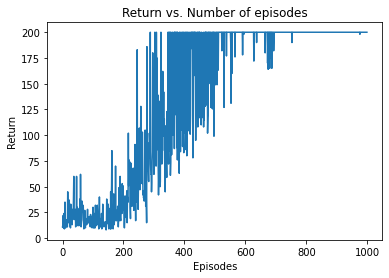

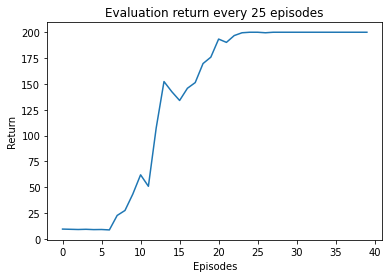

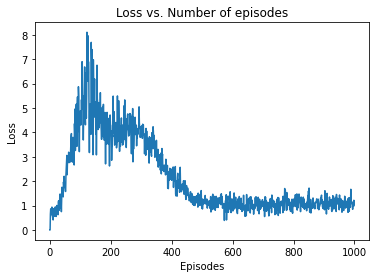

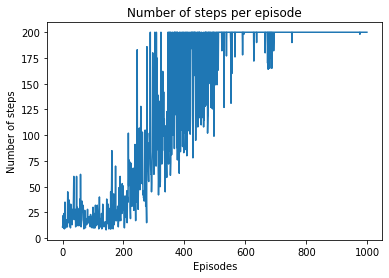

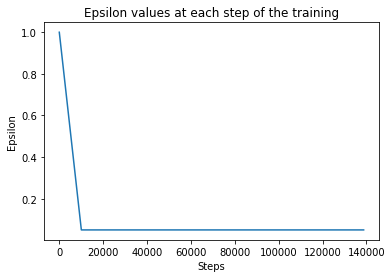

In [13]:
# Plot.
x_axis = range(len(return_list))
plot_result(x_axis, return_list, "Episodes", "Return", title="Return vs. Number of episodes")
plot_result(range(len(eval_return_list)), eval_return_list, "Episodes", "Return", title="Evaluation return every 25 episodes")
plot_result(x_axis, loss_list, "Episodes", "Loss", title="Loss vs. Number of episodes")
plot_result(x_axis, step_list, "Episodes", "Number of steps", title="Number of steps per episode")
plot_result(range(len(epsilon_list)), epsilon_list, "Steps", "Epsilon", title="Epsilon values at each step of the training")

Below, we plot episode loss and undiscounted return over the course of training. After increasing a bit,
the loss slowly starts to decrease after 200 episodes, suggesting that the network is learning. The loss
seems to continue to decrease if we ran for a greater number of episodes but it was not necessary to do
so as we can see on the return plot that the agent has already reached a mean return of 200 after 400
episodes.